## **1. Precision-Recall Curve**

Definition

- Precision: The ratio of true positive predictions to the total number of positive predictions (True Positives + False Positives).

- Recall (or Sensitivity): The ratio of true positive predictions to the total number of actual positives (True Positives + False Negatives).

- The Precision-Recall (PR) Curve plots Precision against Recall for different thresholds.
- It's particularly useful when dealing with imbalanced datasets, where the number of positive instances is much smaller than the number of negative instances.

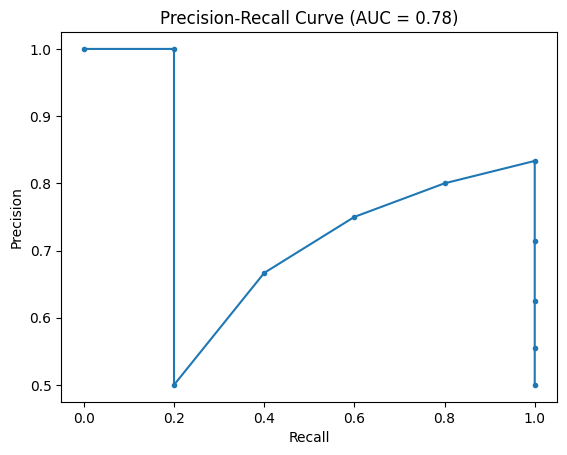

F1 Score: 0.67


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, auc, average_precision_score
import matplotlib.pyplot as plt

# Simulated true labels and predicted probabilities
y_true = np.array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0])
y_scores = np.array([0.1, 0.4, 0.35, 0.8, 0.7, 0.05, 0.2, 0.9, 0.6, 0.3])

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1 = f1_score(y_true, y_scores > 0.5)
auc_score = auc(recall, precision)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.show()

print(f'F1 Score: {f1:.2f}')


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Assuming y_true and y_scores are already defined
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall)

# Finding the index of the maximum F1 Score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold by F1 Score: {best_threshold:.2f}")
print(f"Corresponding Precision: {precision[best_threshold_index]:.2f}")
print(f"Corresponding Recall: {recall[best_threshold_index]:.2f}")


Best Threshold by F1 Score: 0.35
Corresponding Precision: 0.83
Corresponding Recall: 1.00


## **2. ROC Curve**

Definition:

- True Positive Rate (TPR) (or Recall): The ratio of true positive predictions to the total number of actual positives.
- False Positive Rate (FPR): The ratio of false positive predictions to the total number of actual negatives (False Positives + True Negatives).
- The Receiver Operating Characteristic (ROC) Curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for various threshold values.

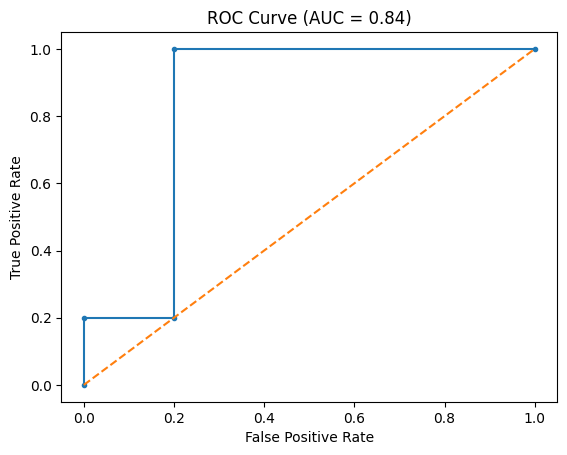

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.show()


Comparison Between Precision-Recall and ROC:

- Precision-Recall Curve: More informative when dealing with imbalanced datasets, as it focuses on the performance related to the minority class.

- ROC Curve: Better when you have a balanced dataset or when you're interested in the overall performance of the model.

In [ ]:
from sklearn.metrics import roc_curve

# Assuming y_true and y_scores are already defined
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
youden_index = tpr - fpr

# Finding the threshold with the maximum Youden's Index
best_threshold_index = np.argmax(youden_index)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold by Youden's Index: {best_threshold:.2f}")
print(f"Corresponding TPR (Sensitivity): {tpr[best_threshold_index]:.2f}")
print(f"Corresponding FPR: {fpr[best_threshold_index]:.2f}")


Best Threshold by Youden's Index: 0.35
Corresponding TPR (Sensitivity): 1.00
Corresponding FPR: 0.20


**Accounting for the new threshold**

In [ ]:
def predict_with_threshold(model, X, threshold):
    # Predict probabilities
    y_scores = model.predict_proba(X)[:, 1]  # Assuming binary classification and taking the probability for class 1
    # Apply the threshold
    return (y_scores >= threshold).astype(int)

# Usage in production
new_predictions = predict_with_threshold(your_model, X_new_data, best_threshold)


## **Implementing ROC, PR Curves and Threshold Selections**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,roc_auc_score
import pickle

In [2]:
data = pd.read_csv("/content/prepared_df.csv")

In [3]:
df_enc = data.copy()

# Encoding the ordinal salary column

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

In [4]:
df_enc = pd.get_dummies(df_enc,drop_first=False)

In [5]:
percentile_25 = df_enc['tenure'].quantile(0.25)
percentile_75 = df_enc['tenure'].quantile(0.75)

iqr = percentile_75 - percentile_25

upper = (percentile_75 + 1.5) * iqr
lower = (percentile_25 - 1.5) * iqr

print(upper)
print(lower)

5.5
1.5


In [6]:
df_lr = df_enc[(df_enc['tenure'] >= lower) & (df_enc['tenure'] <= upper)]

X = df_lr.drop('left',axis=1)
y = df_lr['left']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0,stratify=y)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8375, 18)
(2792, 18)
(8375,)
(2792,)


**Modelling**

In [8]:
lr = LogisticRegression(max_iter=500,random_state=0)

In [9]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate training metrics
    training_accuracy = accuracy_score(y_train, y_pred_train)
    training_precision = precision_score(y_train, y_pred_train)
    training_recall = recall_score(y_train, y_pred_train)
    training_f1 = f1_score(y_train, y_pred_train)

    # Calculate test metrics
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    testing_precision = precision_score(y_test, y_test_pred)
    testing_recall = recall_score(y_test, y_test_pred)
    testing_f1 = f1_score(y_test, y_test_pred)

    # Create a DataFrame with the metrics
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Training': [training_accuracy, training_precision, training_recall, training_f1],
        'Testing': [testing_accuracy, testing_precision, testing_recall, testing_f1]
    })

    return comparison_df

In [10]:
# Logistic Regression

evaluate_model(lr, X_train, y_train, X_test, y_test)

,Metric,Training,Testing
0,Accuracy,0.824955,0.825931
1,Precision,0.462788,0.468619
2,Recall,0.242381,0.237792
3,F1 Score,0.318140,0.315493


In [11]:
from sklearn.metrics import classification_report, roc_curve, auc

In [13]:
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [17]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2321
           1       0.47      0.24      0.32       471

    accuracy                           0.83      2792
   macro avg       0.66      0.59      0.61      2792
weighted avg       0.79      0.83      0.80      2792



**ROC Curve**

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [20]:
# predict the probabilities

y_pred_prob = lr.predict_proba(X_test)[:,-1]

In [23]:
fpr,tpr,threshold = roc_curve(y_test,y_pred_prob)

#roc_auc = auc(fpr,tpr)
auc_score = roc_auc_score(y_test,y_pred_prob)

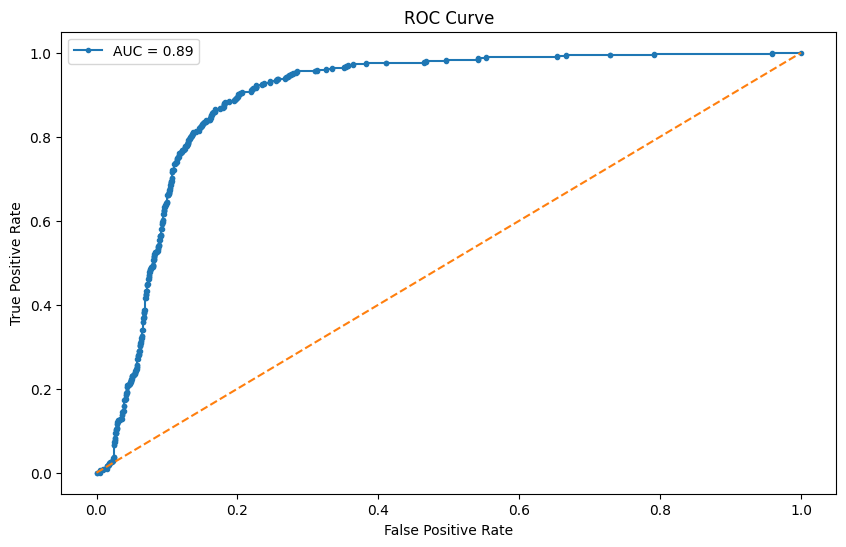

In [26]:
# plot

plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,marker='.',label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

**Threshold Selection**

In [27]:
import numpy as np

In [28]:
diff = tpr - fpr

In [29]:
idx  = np.argmax(diff)

In [33]:
optimal = threshold[idx]
print(f"Optimal Threshold: {optimal:.2f}")

Optimal Threshold: 0.17


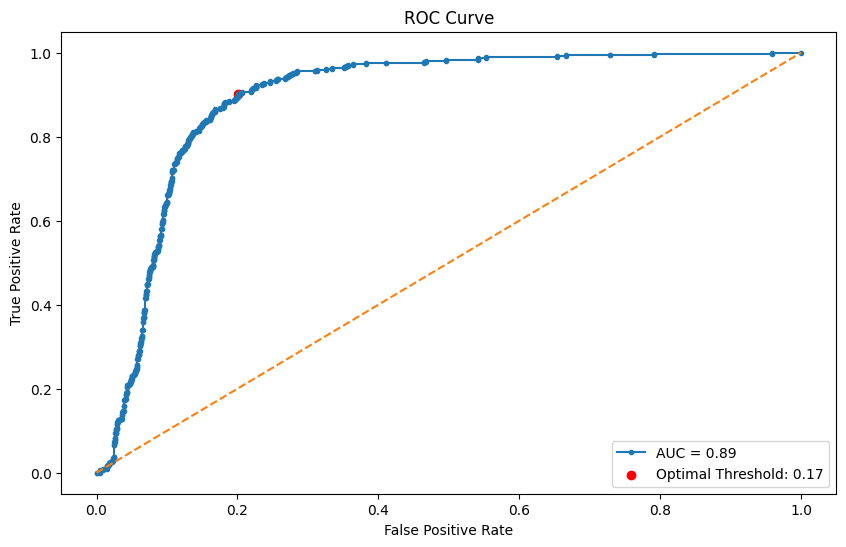

In [34]:
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,marker='.',label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],linestyle='--')
plt.scatter(fpr[idx],tpr[idx],marker='o',color='red',label=f'Optimal Threshold: {optimal:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

In [37]:
y_new_pred = (y_pred_prob >= optimal).astype(int)

In [39]:
new_report = classification_report(y_test,y_new_pred)
print(new_report)

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      2321
           1       0.48      0.90      0.62       471

    accuracy                           0.82      2792
   macro avg       0.73      0.85      0.75      2792
weighted avg       0.89      0.82      0.84      2792



In [40]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2321
           1       0.47      0.24      0.32       471

    accuracy                           0.83      2792
   macro avg       0.66      0.59      0.61      2792
weighted avg       0.79      0.83      0.80      2792



**Precision Recall Curve**

In [41]:
from sklearn.metrics import precision_recall_curve, auc

In [42]:
y_pred_prob

array([0.01994223, 0.02069535, 0.02007761, ..., 0.00330201, 0.0971542 ,
       0.32813504])

In [56]:
precision,recall,thresholds = precision_recall_curve(y_test,y_pred_prob)

In [57]:
auc_score = auc(recall,precision)
print(f"AUC Score (Precision Recall Curve : {auc_score})")

AUC Score (Precision Recall Curve : 0.48689580921720305)


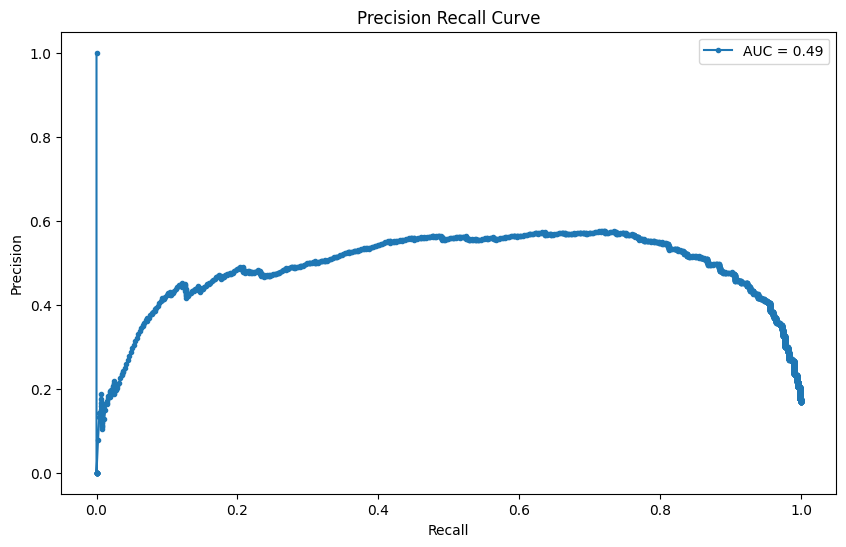

In [45]:
plt.figure(figsize=(10,6))
plt.plot(recall,precision,marker='.',label=f'AUC = {auc_score:.2f}')
# plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Recall Curve')
plt.show()

**Threshold Selection using PR Curve**

In [64]:
recall

array([1., 1., 1., ..., 0., 0., 0.])

In [58]:
# the f1_score for each threshold

f1_score = 2 * (precision * recall) / (precision + recall)

<ipython-input-58-a8ae70d94391>:3: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [59]:
idx = f1_score.argmax()

In [60]:
optimal_pr_threshold = thresholds[idx]
print(f"Optimal Threshold: {optimal_pr_threshold:.2f}")

Optimal Threshold: 0.87


In [61]:
y_pred_pr = (y_pred_prob >= optimal_pr_threshold).astype(int)

In [62]:
pr_report = classification_report(y_test,y_pred_pr)
print(pr_report)

              precision    recall  f1-score   support

           0       0.83      0.99      0.91      2321
           1       0.00      0.00      0.00       471

    accuracy                           0.83      2792
   macro avg       0.42      0.50      0.45      2792
weighted avg       0.69      0.83      0.75      2792



In [54]:
print(new_report)

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      2321
           1       0.48      0.90      0.62       471

    accuracy                           0.82      2792
   macro avg       0.73      0.85      0.75      2792
weighted avg       0.89      0.82      0.84      2792



In [55]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2321
           1       0.47      0.24      0.32       471

    accuracy                           0.83      2792
   macro avg       0.66      0.59      0.61      2792
weighted avg       0.79      0.83      0.80      2792

